# Imports

In [9]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

np.set_printoptions(precision=3, suppress=True)
from IPython.display import clear_output
plt.set_cmap('cividis')


from scipy import interpolate

#specific Neural Network imports

import tensorflow as tf
import keras
import keras_tuner
import keras.backend as K

from keras_tuner import RandomSearch, Hyperband, GridSearch, BayesianOptimization, HyperModel, Objective, Tuner, HyperParameters
from keras import layers
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import load_model, save_model


#imports for scikit learn, for general ML techniques


from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.decomposition import PCA

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()



<Figure size 640x480 with 0 Axes>

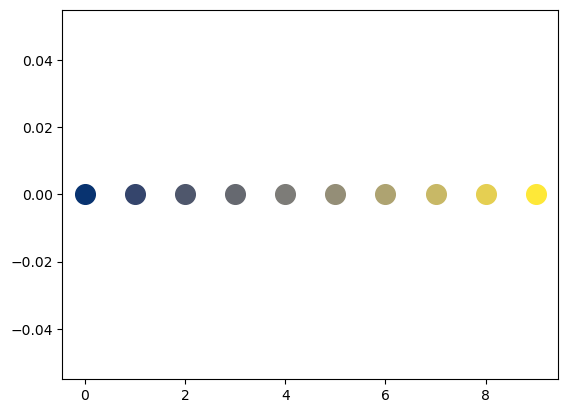

In [11]:
#Creating some colors for use throughout the notebook
cmap = matplotlib.cm.get_cmap('cividis')
colors = [cmap(i) for i in np.arange(0.1, 1.1, 0.1)]
for i, col in enumerate(colors):
  plt.scatter(i, 0, color=colors[i], s=200)

# Get the data

## Importing and preprocess

In [12]:
def getData_profile(filename, outputs=[0], features_start=7):
    #read out the data from a csv file and remove n_period column

    data = pd.read_csv(filename, sep=',', header=0)

    if len(outputs)>1:
        y_df = data.iloc[:, outputs[0]:outputs[-1]+1]
    else:
        y_df = data.iloc[:, outputs[0]]
        
    X_df = data.iloc[:, features_start::]
        
    return y_df, X_df

#y_df, X_df = getData_profile('sims_custom\dens_data_subtr.csv', outputs=[0, 1, 2])
y_df, X_df = getData_profile('04_files/JET_data.csv', outputs=[0, 1, 2, 3])



def add_noise(img, var):
    '''Add random noise to an image'''

    noise = np.random.normal(0, var, img.shape)
    img_noised= noise + img
    return img_noised

def preProcessing_PCA(y_df, X_df, comps=5, test_size=0.2, random_state=0, noise=True, var_noise=0.01):
    #Do all the preprocessing steps for training and validation:
    #Properly expand dimensions
    #Split and renormalize to train max
    #add gaussian noise

    X = np.expand_dims(np.array(X_df), -1) #needed for the convolutional structure
    y = np.array(y_df)


    sss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y[:, 0]))

    x_train, y_train = X[train_idx], y[train_idx]
    x_test, y_test = X[test_idx], y[test_idx]
    
    highest_peak = np.amax(abs(x_train))
    print(highest_peak)
    print(np.amin(x_train))
    x_train /= highest_peak
    x_test  /= highest_peak
    new_max = np.amax(abs(x_train))
    print(new_max)
    #get all the data to be normalized in a sense, to have the largest absolute value of 1
    #then the standard deviation of the noise you add is 1% of this max, quite substantial!
    
    if noise:
        for i, sample in enumerate(x_train):
            x_train[i] = add_noise(sample, var_noise*new_max)
        for i, sample in enumerate(x_test):
            x_test[i] = add_noise(sample, var_noise*new_max)

    pca = PCA(n_components=comps)
    pca.fit(x_train[:, :-1, 0])

    x_pca_train = pca.transform(x_train[:, :-1, 0])
    x_pca_test = pca.transform(x_test[:, :-1, 0])

    return x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca


n_PCA_comps = 20

x_train, x_pca_train, x_test, x_pca_test, y_train, y_test, pca_model = preProcessing_PCA(y_df, X_df, comps=n_PCA_comps, noise=True, var_noise=0.01)


x_train_1, x_pca_train_1, x_test_1, x_pca_test_1, y_train_1, y_test_1, pca_model_1 = preProcessing_PCA(y_df, X_df, comps=n_PCA_comps, noise=False, var_noise=0.01)


39.7141
0.00015
1.0
39.7141
0.00015
1.0


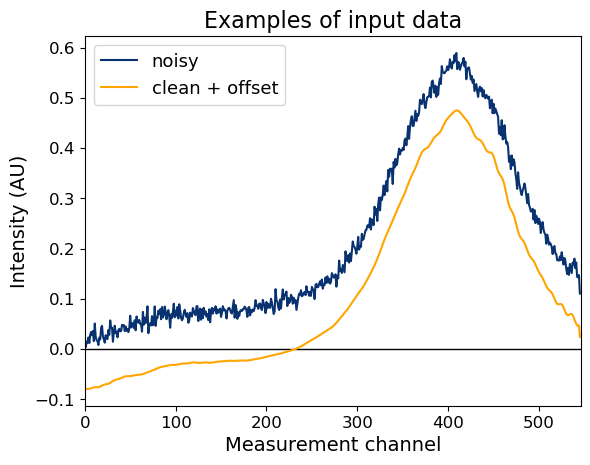

In [13]:
fig, ax = plt.subplots()

ax.hlines(0, xmin=0, xmax=x_train.shape[1], color='black', linewidth=1)
ax.plot(x_train[800, :, 0], c=colors[0], label='noisy')
ax.plot(x_train_1[800, :, 0]-.1, c='orange', label='clean + offset')
ax.legend(loc='upper left', fontsize=13)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Examples of input data', fontsize=16)
ax.set_ylabel(r'Intensity (AU)', fontsize=14)
ax.set_xlabel(r'Measurement channel', fontsize=14)

plt.xlim(0, x_train.shape[1])

plt.savefig('04_files/figures/input_data.pdf', bbox_inches='tight')

## Exploring the PCA analysis for this case

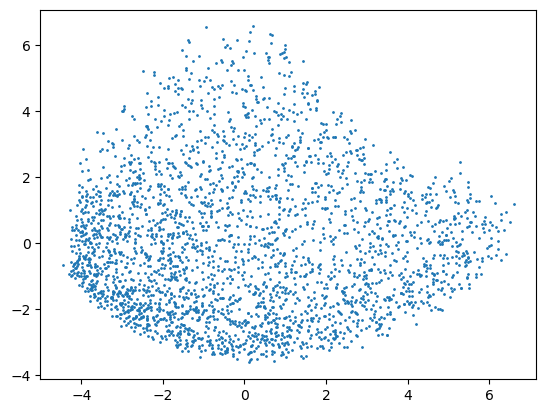

In [14]:
plt.scatter(x_pca_train[:, 0], x_pca_train[:, 1], s=1)

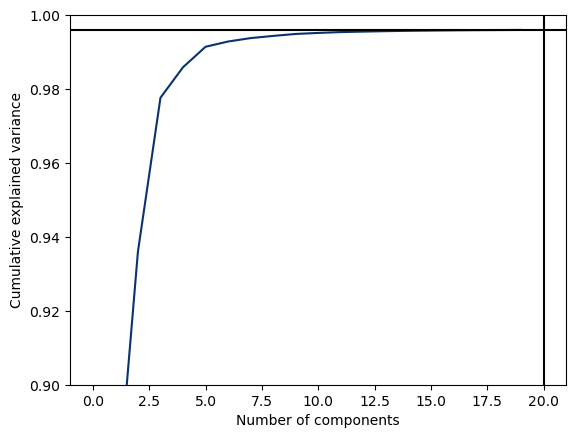

In [15]:
plt.plot(np.cumsum(pca_model.explained_variance_ratio_), c=colors[0])
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.ylim(.9, 1)
plt.axhline(0.996, c='black')
plt.axvline(20, c='black')

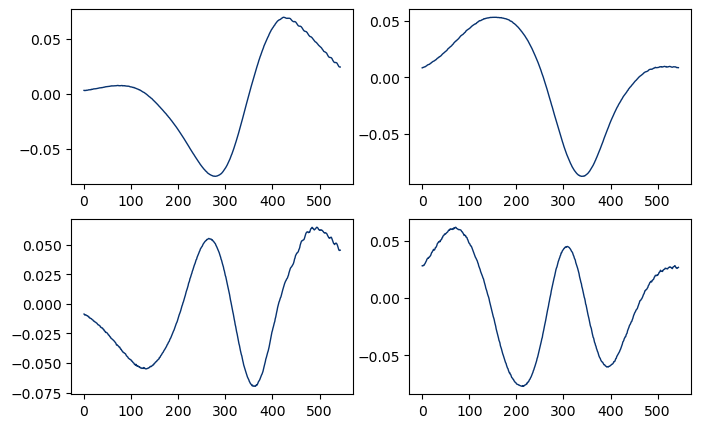

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))

ax[0, 0].plot(pca_model.components_[0], linewidth=1, label='1', c=colors[0])
ax[0, 1].plot(pca_model.components_[1], linewidth=1, label='2', c=colors[0])
ax[1, 0].plot(pca_model.components_[2], linewidth=1, label='3', c=colors[0])
ax[1, 1].plot(pca_model.components_[3], linewidth=1, label='4', c=colors[0])

(0.0, 0.6187767927780277)

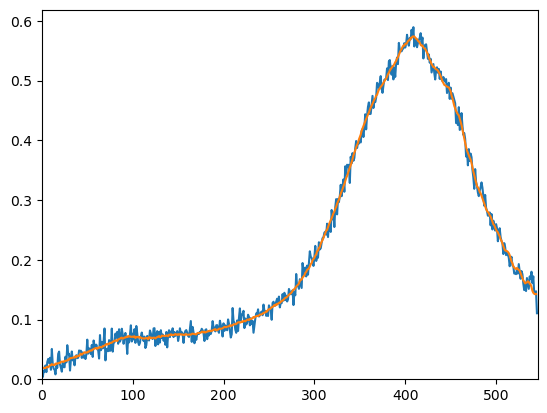

In [17]:
plt.plot(x_train[800, :, 0])

plt.plot(pca_model.inverse_transform(x_pca_train[800]))
plt.xlim(0, x_train.shape[1])
plt.ylim(0)

## The JET profiles

In [18]:
from scipy.optimize import root_scalar
from mpl_toolkits.axes_grid1 import make_axes_locatable

def jet(angle, a, R0, delta, kappa):
    R = R0 + a*np.cos(angle + delta*np.sin(angle))
    z = kappa*a*np.sin(angle)

    return R, z

def inverse(R, z, R0, delta, kappa):
    
    def f(x, R=1, z=1, R0=1, delta=1, kappa=1, neg_side=False):
        theta = np.arcsin(z/(kappa*x))
        if neg_side:
            theta = np.pi - theta

        return x*np.cos(theta + delta*z/(kappa*x)) -R +R0

    try:
        a = root_scalar(f, args=(R, z, R0, delta, kappa), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
        #The extra 1e-13 is to avoid the root finding algorithm to get stuck, as arcsin needs an argument between -1 and 1
        return a, np.arcsin(z/(kappa*a))
    
    except ValueError:
        try:
            #print('Were on the negative side')
            a = root_scalar(f, args=(R, z, R0, delta, kappa, True), bracket=[abs(z/kappa)+1e-13, 2], method='brentq').root
            return a, np.pi - np.arcsin(z/(kappa*a))
    
        except ValueError:
            return 2, np.pi

def jet_profile(a, theta, amplitude=.25, mode_num=4, phase=0.):
    if a>1:
        #This is to avoid the plasma extending beyond the last closed flux surface
        return 0 
    
    elif a< .8:
        #Inside, the density follows the flux surfaces to 1st order
        return np.sqrt(1-a) 
    
    else:
        #between around a=.8 to a=1, we add a perturbation, gaussian in a, sinusoidal in theta
        argument = (mode_num*theta + phase/mode_num if mode_num!=0 else 0)
        return np.sqrt(1-a) + amplitude * np.cos(argument)* np.exp(-((a-.9)/.04)**2) 
    

def make_density(R, z, ne_peak, R0, delta, kappa, profile=jet_profile, amplitude=.0, mode_num=4, phase=0.):

    grid = np.zeros((len(z), len(R)))
    outer_contour_R, outer_contour_z = jet(np.linspace(0, 2*np.pi, 200), 1, R0, delta, kappa)
    RM, Rm, zM, zm = np.amax(outer_contour_R), np.amin(outer_contour_R), np.amax(outer_contour_z), np.amin(outer_contour_z)

    

    for i, R_val in enumerate(R):
        for j, z_val in enumerate(z):
            if R_val > RM or R_val < Rm or z_val > zM or z_val < zm:
                continue
            else:
                contour_value, theta = inverse(R_val, z_val, R0, delta, kappa)
                grid[j, i] = ne_peak *profile(contour_value, theta, amplitude, mode_num, phase)
                # use grid[i, j] to rotate and send from HFS
                # use grid[-i, j] to rotate and send from LFS


    return grid


def mirror(profile):
    return np.concatenate((profile[::-1, :], profile), axis=0)

def plot_JET(profile):

    R = np.linspace(1.6, 4.4, 40)
    z = np.linspace(0, 1.7, 40)
    z2 = np.linspace(-1.7, 1.7, 80)

    X2, Z2 = np.meshgrid(R, z2)

    full = mirror(profile)
    fig, ax = plt.subplots(figsize=(5, 5))

    ax.contourf(X2, Z2, full, levels=200, cmap='cividis')
    ax.contour(X2, Z2, full, levels=8, colors='black', linewidths=1)
    ax.contour(X2, Z2, full, levels=[0], colors='white', linewidths=1)
    ax.set_aspect('equal')
    return
    


In [19]:
y_train.shape

(2880, 4)

C:\Users\ewout\AppData\Local\Temp\ipykernel_159316\748012790.py:30: UserWarning: No contour levels were found within the data range.
  ax[0].contour(X2, Z2,JET_full, levels=[0], colors='white', linewidths=1)


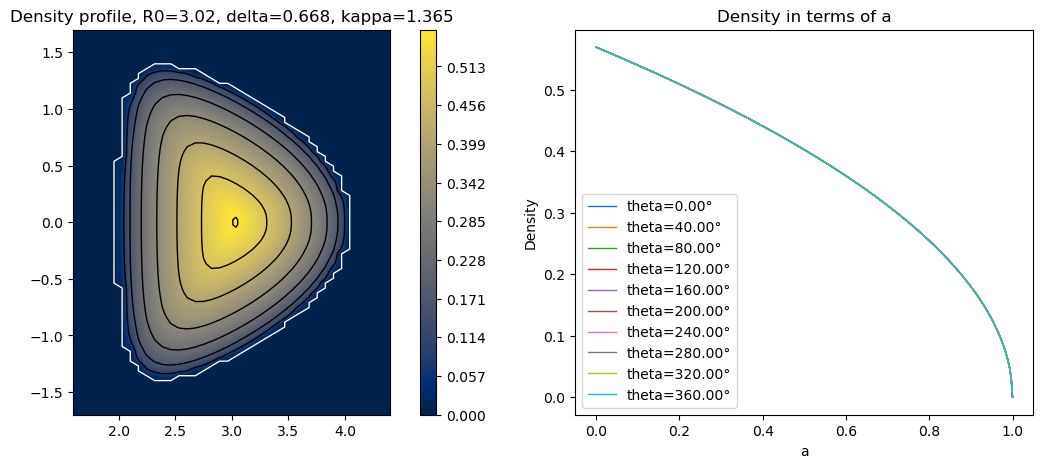

In [20]:

ne_peak= y_train[0, 0]
R0 = y_train[0, 1]
delta = y_train[0, 2]
kappa = y_train[0, 3]
amplitude = 0.
mode_num = 0
phase = 0

R = np.linspace(1.6, 4.4, 40)
z = np.linspace(0, 1.7, 40)
z2 = np.linspace(-1.7, 1.7, 80)

X2, Z2 = np.meshgrid(R, z2)


JET_example = make_density(R,z, ne_peak, R0, delta, kappa, jet_profile, amplitude, mode_num, phase)

JET_full = mirror(JET_example)
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
cont = ax[0].contourf(X2, Z2, JET_full, levels=200, cmap='cividis')
#cont = ax[0].imshow(JET_full, cmap='cividis')
ax[0].set_aspect('equal')
ax[0].set_title(f'Density profile, R0={R0}, delta={delta}, kappa={kappa}')
divider_1 = make_axes_locatable(ax[0])
cax = divider_1.append_axes("right", size="5%", pad=0.3)

contours = True
if contours:
    ax[0].contour(X2, Z2,JET_full, levels=8, colors='black', linewidths=1)
    ax[0].contour(X2, Z2,JET_full, levels=[0], colors='white', linewidths=1)

plt.colorbar(cont, cax=cax)


a_vals= np.linspace(0, 1, 300)
thetas = np.linspace(0, 2*np.pi, 10)
prof = np.array([[ne_peak*jet_profile(a, theta, amplitude, mode_num, phase) for a in a_vals] for theta in thetas])
for i in range(len(thetas)):
    ax[1].plot(a_vals, prof[i], linewidth=1, label=f'theta={(thetas[i]/np.pi*180):.2f}°')
ax[1].set_xlabel('a')
ax[1].set_ylabel('Density')
ax[1].set_title('Density in terms of a')
ax[1].legend()

## Generating the resolved training data

In [21]:
"""Making new training and testing data, by now having the output as the resolved images"""

y_train_new = np.array([make_density(R, z, train_sample[0], train_sample[1], train_sample[2], train_sample[3])
 for _, train_sample in enumerate(y_train)])
y_test_new = np.array([make_density(R, z, test_sample[0], test_sample[1], test_sample[2], test_sample[3])
 for _, test_sample in enumerate(y_test)])

y_test_new.shape

(720, 40, 40)

C:\Users\ewout\AppData\Local\Temp\ipykernel_159316\1494078947.py:86: UserWarning: No contour levels were found within the data range.
  ax.contour(X2, Z2, full, levels=[0], colors='white', linewidths=1)


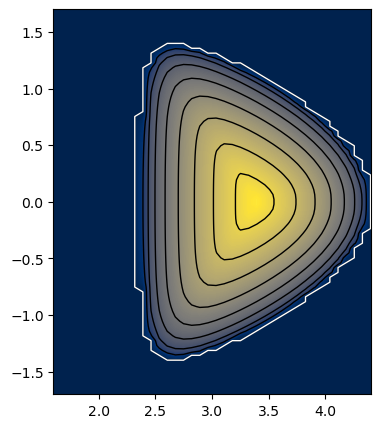

In [22]:
index = 6

plot_JET(y_train_new[index])

## The loss functions

In [23]:
def mse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))

    return mse 

def rmse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))
    rmse = K.sqrt(mse)

    return rmse

def nrmse(y_true, y_pred):
    # Define the custom loss function here
    mse = K.mean(K.square(y_true - y_pred))
    rmse = K.sqrt(mse)
    min_val = K.min(y_true)
    max_val = K.max(y_true)
    return rmse / (max_val - min_val)

def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# For evaluation

from skimage.metrics import structural_similarity as ssim

#non-differentiable, don't use for training!

def ssim_loss(y_true, y_pred):
    # Define the custom loss function here
    return  ssim(y_true, y_pred, multichannel=True)

def psnr(y_true, y_pred):
    max_pixel = K.max(y_true)
    return 20 * K.log(max_pixel / K.sqrt(K.mean(K.square(y_true - y_pred)))) / K.log(10.0)

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))


def loss_split(y_true, y_pred, frac=0.5):
    return frac*SSIMLoss(y_true, y_pred) + (1-frac)*nrmse(y_true, y_pred)

# Model generation

In [24]:
x_train.shape

(2880, 546, 1)

In [42]:
def create_JET_model(hp):
    model = tf.keras.models.Sequential()

    model.add(layers.AveragePooling1D(pool_size=5, strides=2, padding='same', name='pool1'))

    for i in range(hp.Int("num__conv_layers", 2, 3, default=3)):

        kernelsize = int(np.max([3, (2**(4-i)-1)]))
        model.add(layers.Conv1D(np.min([8*(2**i), 32]), kernel_size=kernelsize, padding='same', name=f'conv{i+1}'))
        model.add(layers.LeakyReLU())
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling1D(pool_size=2, strides=2,padding='same', name=f'pool{i+2}'))

    model.add(layers.Flatten(name='flatten'))

    rate = hp.Choice(f'droprate', [.1, .15, .2, .25], default=.15)
    for i in range(hp.Int("num__dens_layers", 1, 2, default=2)):
        if hp.Boolean("dropout", default=True):
            model.add(keras.layers.Dropout(rate=rate, name=f'drop{i+1}'))
        model.add(layers.Dense(units=hp.Int(f"units_{i+1}", min_value=500, max_value=1500, step=250, default=1250)
                                        , activation='relu', name=f'dens{i+1}'))

    model.add(layers.Reshape((5, 5, -1)))

    model.add(layers.Conv2DTranspose(8, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
   
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    model.add(layers.Conv2D(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='relu'))
    """
    lr_schedule = schedules.ExponentialDecay(
                    initial_learning_rate=1e-2,
                    decay_steps=50,
                    decay_rate=0.9)
    """
    optimizer = getattr(tf.keras.optimizers, "Adam")(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=0.0005))
    loss_func = hp.Choice("loss_func", ["nrmse", "ssim", "loss_split"], default="loss_split")
    if loss_func == "nrmse":
        model.compile(optimizer=optimizer, loss=nrmse)
    elif loss_func == "ssim":
        model.compile(optimizer=optimizer, loss=SSIMLoss)
    elif loss_func == "loss_split":
        model.compile(optimizer=optimizer, loss=loss_split)

    return model

# Tuning hyperparameters

In [43]:
#This lets you tune single parameters or a few at once, with the rest set to standard value.

#For the others, the default is set inside the function create_resolved_model

hp = keras_tuner.HyperParameters()

#so only the following are tunable

hp.Int(f"units_{2}", min_value=1500, max_value=1500, step=250)





1500

In [44]:
tuner = BayesianOptimization(
    hypermodel=create_JET_model,
    hyperparameters=hp,
    # Prevents unlisted parameters from being tuned
    tune_new_entries=False,
    objective="val_loss",
    max_trials=1,
    alpha=2e-3,
    beta=2.6,
    executions_per_trial=1,
    overwrite=True,
    directory="04_files/tuning",
    project_name="JET_tuning"
)

In [45]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 1500, 'max_value': 1500, 'step': 250, 'sampling': 'linear'}


In [47]:
tuner.search(x_train, y_train_new, validation_split=0.2, epochs=5, batch_size=64)

Trial 1 Complete [00h 00m 13s]
val_loss: 0.3269656002521515

Best val_loss So Far: 0.3269656002521515
Total elapsed time: 00h 00m 24s
INFO:tensorflow:Oracle triggered exit


In [48]:
vals = tuner.get_best_hyperparameters()[0].values
vals

{'units_2': 1500,
 'num__conv_layers': 3,
 'droprate': 0.15,
 'num__dens_layers': 2,
 'dropout': True,
 'units_1': 1250,
 'learning_rate': 0.0005,
 'loss_func': 'loss_split'}

In [49]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 546, 1))
best_model.summary()
save_model(best_model, "04_files/tuning/best_model.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pool1 (AveragePooling1D)    (None, 273, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 273, 8)            128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 273, 8)            0         
                                                                 
 batch_normalization (BatchN  (None, 273, 8)           32        
 ormalization)                                                   
                                                                 
 pool2 (MaxPooling1D)        (None, 137, 8)            0         
                                                                 
 conv2 (Conv1D)              (None, 137, 16)           912       
                                                        

In [50]:
model_result = load_model("04_files/tuning/best_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
model_result.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pool1 (AveragePooling1D)    (None, 273, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 273, 8)            128       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 273, 8)            0         
                                                                 
 batch_normalization (BatchN  (None, 273, 8)           32        
 ormalization)                                                   
                                                                 
 pool2 (MaxPooling1D)        (None, 137, 8)            0         
                                                                 
 conv2 (Conv1D)              (None, 137, 16)           912       
                                                        

# Retraining ideal model

In [51]:
vals = tuner.get_best_hyperparameters(3)
vals[0].values

{'units_2': 1500,
 'num__conv_layers': 3,
 'droprate': 0.15,
 'num__dens_layers': 2,
 'dropout': True,
 'units_1': 1250,
 'learning_rate': 0.0005,
 'loss_func': 'loss_split'}

In [52]:
hp_nrmse = keras_tuner.HyperParameters()


#hp_nrmse.Int(f"units_{2}", min_value=500, max_value=500, step=250)
hp_nrmse.Choice(f"loss_func", values=['nrmse'])

'nrmse'

In [53]:
hp_ssim = keras_tuner.HyperParameters()


#hp_ssim.Int(f"units_{2}", min_value=500, max_value=500, step=250)
hp_ssim.Choice(f"loss_func", values=['ssim'])

'ssim'

In [54]:
model_split = create_JET_model(vals[0])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('04_files/tuning/optimised_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_split = model_split.fit(x_train, y_train_new, validation_split=0.2, epochs=400, batch_size=64, verbose=1, callbacks=[es, mc_full])

Epoch 1/400
36/36 [==============================] - 4s 69ms/step - loss: 0.4566 - val_loss: 0.4405
Epoch 2/400
36/36 [==============================] - 2s 60ms/step - loss: 0.3470 - val_loss: 0.4087
Epoch 3/400
36/36 [==============================] - 2s 60ms/step - loss: 0.2500 - val_loss: 0.3494
Epoch 4/400
36/36 [==============================] - 2s 62ms/step - loss: 0.1508 - val_loss: 0.3316
Epoch 5/400
36/36 [==============================] - 2s 60ms/step - loss: 0.1181 - val_loss: 0.3287
Epoch 6/400
36/36 [==============================] - 2s 61ms/step - loss: 0.1017 - val_loss: 0.3257
Epoch 7/400
36/36 [==============================] - 2s 59ms/step - loss: 0.0890 - val_loss: 0.3206
Epoch 8/400
36/36 [==============================] - 2s 60ms/step - loss: 0.0801 - val_loss: 0.3075
Epoch 9/400
36/36 [==============================] - 2s 61ms/step - loss: 0.0743 - val_loss: 0.2947
Epoch 10/400
36/36 [==============================] - 2s 59ms/step - loss: 0.0687 - val_loss: 0.2894

In [55]:
model_nrmse = create_JET_model(hp_nrmse)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('04_files/tuning/nrmse_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_nrmse = model_nrmse.fit(x_train, y_train_new, validation_split=0.2, epochs=400, batch_size=64, verbose=1, callbacks=[es, mc_full])

Epoch 1/400
36/36 [==============================] - 3s 55ms/step - loss: 0.2053 - val_loss: 0.2235
Epoch 2/400
36/36 [==============================] - 2s 49ms/step - loss: 0.1803 - val_loss: 0.2118
Epoch 3/400
36/36 [==============================] - 2s 49ms/step - loss: 0.1329 - val_loss: 0.1884
Epoch 4/400
36/36 [==============================] - 2s 50ms/step - loss: 0.0716 - val_loss: 0.1752
Epoch 5/400
36/36 [==============================] - 2s 48ms/step - loss: 0.0561 - val_loss: 0.1662
Epoch 6/400
36/36 [==============================] - 2s 48ms/step - loss: 0.0494 - val_loss: 0.1580
Epoch 7/400
36/36 [==============================] - 2s 50ms/step - loss: 0.0454 - val_loss: 0.1510
Epoch 8/400
36/36 [==============================] - 2s 50ms/step - loss: 0.0422 - val_loss: 0.1300
Epoch 9/400
36/36 [==============================] - 2s 50ms/step - loss: 0.0386 - val_loss: 0.1249
Epoch 10/400
36/36 [==============================] - 2s 50ms/step - loss: 0.0380 - val_loss: 0.1081

In [56]:
model_ssim = create_JET_model(hp_ssim)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
mc_full = ModelCheckpoint('04_files/tuning/ssim_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

history_ssim = model_split.fit(x_train, y_train_new, validation_split=0.2, epochs=400, batch_size=64, verbose=1, callbacks=[es, mc_full])

Epoch 1/400
36/36 [==============================] - 3s 73ms/step - loss: 0.0139 - val_loss: 0.0311
Epoch 2/400
36/36 [==============================] - 3s 72ms/step - loss: 0.0141 - val_loss: 0.0291
Epoch 3/400
36/36 [==============================] - 2s 69ms/step - loss: 0.0143 - val_loss: 0.0311
Epoch 4/400
36/36 [==============================] - 3s 70ms/step - loss: 0.0143 - val_loss: 0.0354
Epoch 5/400
36/36 [==============================] - 3s 73ms/step - loss: 0.0138 - val_loss: 0.0290
Epoch 6/400
36/36 [==============================] - 2s 69ms/step - loss: 0.0140 - val_loss: 0.0365
Epoch 7/400
36/36 [==============================] - 3s 70ms/step - loss: 0.0141 - val_loss: 0.0339
Epoch 8/400
36/36 [==============================] - 3s 70ms/step - loss: 0.0146 - val_loss: 0.0328
Epoch 9/400
36/36 [==============================] - 3s 71ms/step - loss: 0.0140 - val_loss: 0.0362
Epoch 10/400
36/36 [==============================] - 2s 69ms/step - loss: 0.0139 - val_loss: 0.0311

In [90]:
optimised_result = model_split
ssim_result = model_ssim
nrmse_result = model_nrmse
"""
optimised_result = load_model("04_files/tuning/optimised_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
ssim_result = load_model("04_files/tuning/ssim_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
nrmse_result = load_model("04_files/tuning/nrmse_model.h5", custom_objects={'loss_split': loss_split, 'nrmse': nrmse, 'SSIMLoss': SSIMLoss, 'ssim': ssim, 'psnr': psnr, 'mae': mae})
"""


'\noptimised_result = load_model("04_files/tuning/optimised_model.h5", custom_objects={\'loss_split\': loss_split, \'nrmse\': nrmse, \'SSIMLoss\': SSIMLoss, \'ssim\': ssim, \'psnr\': psnr, \'mae\': mae})\nssim_result = load_model("04_files/tuning/ssim_model.h5", custom_objects={\'loss_split\': loss_split, \'nrmse\': nrmse, \'SSIMLoss\': SSIMLoss, \'ssim\': ssim, \'psnr\': psnr, \'mae\': mae})\nnrmse_result = load_model("04_files/tuning/nrmse_model.h5", custom_objects={\'loss_split\': loss_split, \'nrmse\': nrmse, \'SSIMLoss\': SSIMLoss, \'ssim\': ssim, \'psnr\': psnr, \'mae\': mae})\n'

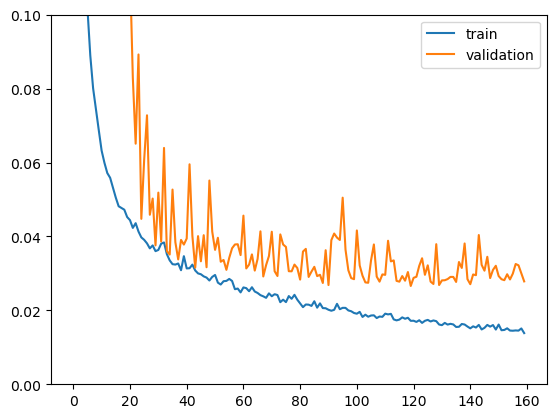

In [91]:
plt.plot(history_split.history['loss'], label='train')
plt.plot(history_split.history['val_loss'], label='validation')

#plt.yscale('log')
plt.legend()
plt.ylim(0, .1)
#plt.axhline(0.03, c='black')
plt.show()

In [92]:
optimised_result.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pool1 (AveragePooling1D)    (None, 273, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 273, 8)            128       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 273, 8)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 273, 8)           32        
 hNormalization)                                                 
                                                                 
 pool2 (MaxPooling1D)        (None, 137, 8)            0         
                                                                 
 conv2 (Conv1D)              (None, 137, 16)           912       
                                                      

## Visual comparison

In [113]:
def ResCompareProfiles(model, x, y, save_figures=False):
    index = 0
    counter = 0
    while index != -1:
        counter +=1
        clear_output()
        plt.set_cmap('cividis')

        prediction = mirror(model.predict(np.expand_dims(x[index], 0)).reshape((40, 40)))
        print(prediction.shape)
        truth = mirror(y[index].reshape((40, 40)))

        


        fig, ax = plt.subplots(1, 3, figsize=(11, 5))

        ax[0].fill_between(np.arange(0, 40), 0, prediction[40, :], color=colors[0], alpha=0.1)

        im_true = ax[0].plot(truth[40, :], label='Ground truth', linestyle='--', c='orange')
        ax[0].set_xlabel('Position along major axis', fontsize=14)
        ax[0].set_ylabel(r'$n_e/n_{crit}$', fontsize=16)

        ax[0].plot(prediction[40, :], label='Prediction', c=colors[0])
        ax[0].set_xlim((0, 39))
        ax[0].set_ylim((0, .6))
        ax[0].legend(loc='upper left', fontsize=9)
        ax[0].tick_params(axis='both', which='major', labelsize=12)
        
        #true = ax[1].imshow(norm_true, vmax=255, vmin=(min_value*255).astype(int))
        true = ax[1].contourf(truth, vmax=0.5, vmin=0, levels=200)
        ax[1].contour(truth, levels=np.arange(0.05, 1, .05), colors='black', linewidths=.7)
        ax[1].set_title('True profile', fontsize=14)
        ax[1].tick_params(axis='both', which='major', labelsize=12)
        #ax[2].imshow(norm_pred, vmax=255, vmin=(min_value*255).astype(int))
        ax[2].contourf(prediction, vmax=0.5, vmin=0, levels=200)
        ax[2].contour(prediction, levels=np.arange(0.05, 1, .05), colors='black', linewidths=.7)
        #ax[2].imshow(prediction, vmax=0.8, vmin=0)
        ax[2].set_title('Predicted profile', fontsize=14)
        ax[2].tick_params(axis='both', which='major', labelsize=12)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.13, 0.02, 0.725]) # [left, bottom, width, height] 
        #//make the cbar_ax above be abit closer to the ax[2] figure

        norm = matplotlib.colors.Normalize(vmin=0, vmax=.5)
        cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='cividis'), cax=cbar_ax)
        cbar.ax.tick_params(labelsize=12)
        if save_figures:
            plt.savefig(f'04_files/figures/compare/{counter}.png', dpi=300)
        


        plt.show()

        index = int(input(f"Select new index, -1 to stop: "))

    return


1/1 [==============================] - 0s 22ms/step
(80, 40)


<Figure size 640x480 with 0 Axes>

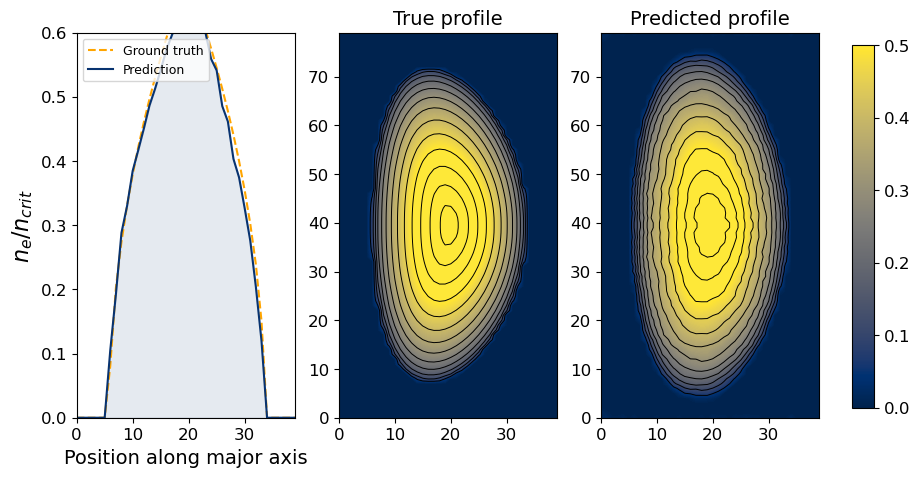

In [120]:
ResCompareProfiles(nrmse_result, x_test, y_test_new, save_figures=True)

In [121]:
import os

os.system("ffmpeg  -r 1/1.5 -i ./04_files/figures/compare/%d.png -vb 20M -vcodec mpeg4 -y ./04_files/figures/compare/profiles.mp4")

0

# Full comparison

In [122]:
predictions_split = optimised_result.predict(x_test)
predictions_ssim = ssim_result.predict(x_test)
predictions_nrmse = nrmse_result.predict(x_test)

23/23 [==============================] - 0s 9ms/step


In [123]:
def get_peak(elem):
    return elem[0]

y_sorted = np.array([[peak.astype(np.float64), resolved] for peak, resolved in sorted(zip(y_test[:, 0], y_test_new), key=get_peak)])
pred_split_sorted = np.array(sorted(zip(y_test[:, 0], predictions_split), key=get_peak)) #change back to resolved_a here later
pred_ssim_sorted = np.array(sorted(zip(y_test[:, 0], predictions_ssim), key=get_peak))
pred_nrmse_sorted = np.array(sorted(zip(y_test[:, 0], predictions_nrmse), key=get_peak))

densities = y_sorted[:, 0]

#densities = densities[:500]

MAE_split_sorted = np.array([mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_split_sorted[i, 1]) for i in range(len(densities))])
MAE_ssim_sorted = np.array([mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_ssim_sorted[i, 1]) for i in range(len(densities))])
MAE_nrmse_sorted = np.array([mae(y_sorted[i, 1].reshape((40, 40, 1)), pred_nrmse_sorted[i, 1]) for i in range(len(densities))])

C:\Users\ewout\AppData\Local\Temp\ipykernel_159316\1417760312.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_sorted = np.array([[peak.astype(np.float64), resolved] for peak, resolved in sorted(zip(y_test[:, 0], y_test_new), key=get_peak)])
C:\Users\ewout\AppData\Local\Temp\ipykernel_159316\1417760312.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_split_sorted = np.array(sorted(zip(y_test[:, 0], predictions_split), key=get_peak)) #change back to resolved_a here later
C:\Users\ewout\AppData\Local\Temp\ipykernel_159316\1417760312.py:6: 

In [124]:
print(np.mean(MAE_split_sorted))
print(np.mean(MAE_ssim_sorted))
print(np.mean(MAE_nrmse_sorted))


0.006162414673321871
0.08752433006466186
0.00567073858385996


float64


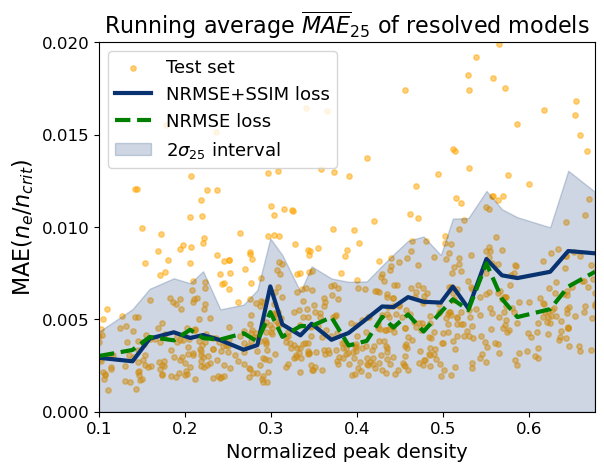

In [140]:
fig, ax = plt.subplots()

ax.scatter(densities, MAE_nrmse_sorted, s=15, alpha=0.5, c='orange', label='Test set')
#ax.scatter(densities, MAE_split_sorted_parametric, s=4, c='indianred', label = 'Parametric')


mean_25_split = []
mean_25_ssim = []
mean_25_nrmse = []
stdev_25 = []

for i in range(0 , len(MAE_split_sorted), 25): 
    #// Also calculate the standard deviation of the 25 points
    mean_25_split_points = sum(MAE_split_sorted[i:i+25])/25  # Calculate mean of 10 points  
    mean_25_ssim_points = sum(MAE_ssim_sorted[i:i+25])/25  # Calculate mean of 10 points
    mean_25_nrmse_points = sum(MAE_nrmse_sorted[i:i+25])/25  # Calculate mean of 10 points

    med_25_split_points = np.median(MAE_split_sorted[i:i+25])  # Calculate mean of 10 points
    med_25_ssim_points = np.median(MAE_ssim_sorted[i:i+25])  # Calculate mean of 10 points
    med_25_nrmse_points = np.median(MAE_nrmse_sorted[i:i+25])  # Calculate mean of 10 points


    mean_25_split.append(med_25_split_points) # Append the values in the list  
    mean_25_ssim.append(med_25_ssim_points) # Append the values in the list
    mean_25_nrmse.append(med_25_nrmse_points) # Append the values in the list

    #change the lines above back to mean when you want to use mean instead of median

    variance_25 = sum(((MAE_split_sorted[i:i+25] - mean_25_split_points) ** 2)) / 25 
    stdev_25.append(variance_25**0.5)


     # Plot the line graph
ax.plot(densities[::25],mean_25_split, c=colors[0], linewidth=3, linestyle='-', label=r'NRMSE+SSIM loss')
#ax.plot(densities[::25],mean_25_ssim, c='red', linewidth=3, linestyle='--', label=r'SSIM loss')
ax.plot(densities[::25],mean_25_nrmse, c='green', linewidth=3, linestyle='--', label=r'NRMSE loss')

ax.fill_between(np.array(densities[::25], dtype=float), 0,
 np.array(mean_25_split, dtype=float) + np.array(stdev_25, dtype=float), color=colors[0], alpha=0.2, label=r'$2\sigma_{25}$ interval')
 # label=r'$\overline{MAE}_{25} + 2\sigma_{25}$'

ax.legend(loc='upper left', fontsize=13)
ax.set_ylim((0, .02))
ax.set_xlim((0.1, densities[::25][-1]))

ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title('Running average $\overline{MAE}_{25}$ of resolved models', fontsize=16)
ax.set_xlabel(r'Normalized peak density', fontsize=14)
ax.set_ylabel(r'MAE($n_e/n_{crit}$)', fontsize=16)


print(np.array(densities[::25], dtype=float).dtype)

plt.savefig('04_files/figures/Com_MAE_resolved.pdf', bbox_inches='tight')


"""----------------------------------"""

In [136]:
print(np.mean(mae(y_test_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(mae(y_test_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(mae(y_test_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

tf.Tensor(0.00616241467332187, shape=(), dtype=float64)
tf.Tensor(0.08752433006466184, shape=(), dtype=float64)
tf.Tensor(0.005670738583859961, shape=(), dtype=float64)


In [137]:
print(np.mean(nrmse(y_test_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(nrmse(y_test_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(nrmse(y_test_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

tf.Tensor(0.020216720458649973, shape=(), dtype=float64)
tf.Tensor(0.22676486706416432, shape=(), dtype=float64)
tf.Tensor(0.019006887664664567, shape=(), dtype=float64)


In [138]:
print(np.mean(ssim_loss(y_test_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(ssim_loss(y_test_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(ssim_loss(y_test_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

C:\Users\ewout\AppData\Local\Temp\ipykernel_159316\1319621768.py:33: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return  ssim(y_true, y_pred, multichannel=True)
c:\Users\ewout\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


0.9793975423807966
0.41624759841088305
0.9783404677989795


In [139]:
print(np.mean(psnr(y_test_new.reshape((720, 40, 40)), predictions_split.reshape((720, 40, 40)))))
print(np.mean(psnr(y_test_new.reshape((720, 40, 40)), predictions_ssim.reshape((720, 40, 40)))))
print(np.mean(psnr(y_test_new.reshape((720, 40, 40)), predictions_nrmse.reshape((720, 40, 40)))))

tf.Tensor(33.88578540861824, shape=(), dtype=float64)
tf.Tensor(12.88848442701592, shape=(), dtype=float64)
tf.Tensor(34.42177936324552, shape=(), dtype=float64)
